# Norman 2019 Training Demo

In [1]:
import sys
#if branch is stable, will install via pypi, else will install from source
branch = "stable"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install cpa-tools
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/theislab/cpa

In [2]:
import os
os.chdir('/home/mohsen/projects/cpa/')
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
import cpa
import scanpy as sc

Global seed set to 0


In [4]:
sc.settings.set_figure_params(dpi=100)

In [5]:
data_path = '/home/mohsen/projects/cpa/datasets/Norman2019_prep_new.h5ad'

In [6]:
adata = sc.read(data_path, backup_url='https://drive.google.com/u/0/uc?id=1pxT0fvXtqBBtdv1CCPVwJaMLHe9XpMHo&export=download&confirm=t')
adata

AnnData object with n_obs × n_vars = 108497 × 5000
    obs: 'cov_drug_dose_name', 'dose_val', 'control', 'condition', 'guide_identity', 'drug_dose_name', 'cell_type', 'split', 'split1', 'split2', 'split3', 'split4', 'split5', 'split6', 'split7', 'split8', 'split9', 'split10', 'split11', 'split12', 'split13', 'split14', 'split15', 'split16', 'split17', 'split18', 'split19', 'split20', 'split21', 'split22', 'split23', 'split24', 'split25'
    var: 'gene_symbols', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'rank_genes_groups_cov'
    layers: 'counts'

In [7]:
cpa.CPA.setup_anndata(adata, 
                      perturbation_keys={
                          'perturbation': 'condition',
                          'dosage': 'dose_val',
                      },
                      control_key='control',
                      categorical_covariate_keys=['cell_type'],
                     )

100%|██████████| 108497/108497 [00:06<00:00, 15936.05it/s]


INFO     Generating sequential column names                                                  


In [8]:
ae_hparams = {'adversary_depth': 3,
              'adversary_width': 256,
              'autoencoder_depth': 4,
              'autoencoder_width': 512,
              'dosers_depth': 3,
              'dosers_width': 32,
              'use_batch_norm': True,
              'use_layer_norm': False,
              'dropout_rate': 0.0,
              'variational': False,
              'seed': 0,
              }

trainer_params = {
    'n_epochs_warmup': 0,
    'adversary_lr': 0.00012219948594647382,
    'adversary_steps': 2,
    'adversary_wd': 1.4033946047401463e-05,
    'autoencoder_lr': 0.00014147035543889223,
    'autoencoder_wd': 2.2782368178455333e-08,
    'dosers_lr': 0.0007022363227033381,
    'dosers_wd': 6.249509305603141e-06,
    'penalty_adversary': 0.013702812231919399,
    'reg_adversary': 4.02272482876072,
    'step_size_lr': 45,
    'cycle_coeff': 7.5,
}

In [9]:
model = cpa.CPA(adata=adata, 
                n_latent=128,
                loss_ae='gauss',
                doser_type='logsigm',
                split_key='split',
                **ae_hparams,
               )

Global seed set to 0


In [10]:
model.train(max_epochs=2000,
            use_gpu=True, 
            batch_size=1024,
            early_stopping=True,
            plan_kwargs=trainer_params,
            early_stopping_patience=15,
            check_val_every_n_epoch=5,
            save_path='/home/mohsen/projects/cpa/lightning_logs/Norman2019_prep_new/',
           )

/home/mohsen/miniconda3/envs/cpa/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=True)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=True)`.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/mohsen/miniconda3/envs/cpa/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:143: LightningDeprecationWarning: The `LightningModule.get_progress_bar_dict` method was deprecated in v1.5 and will be removed in v1.7. Please use the `ProgressBarBase.get_metrics` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Epoch 95/2000:   5%|▍         | 95/2000 [06:48<2:16:23,  4.30s/it, recon=-1.29, cycle_recon=-1.29, val_recon=-2.58, val_disnt_basal=0.0154, val_disnt_after=0.0521, val_reg_mean=0.931, val_reg_var=0.425]


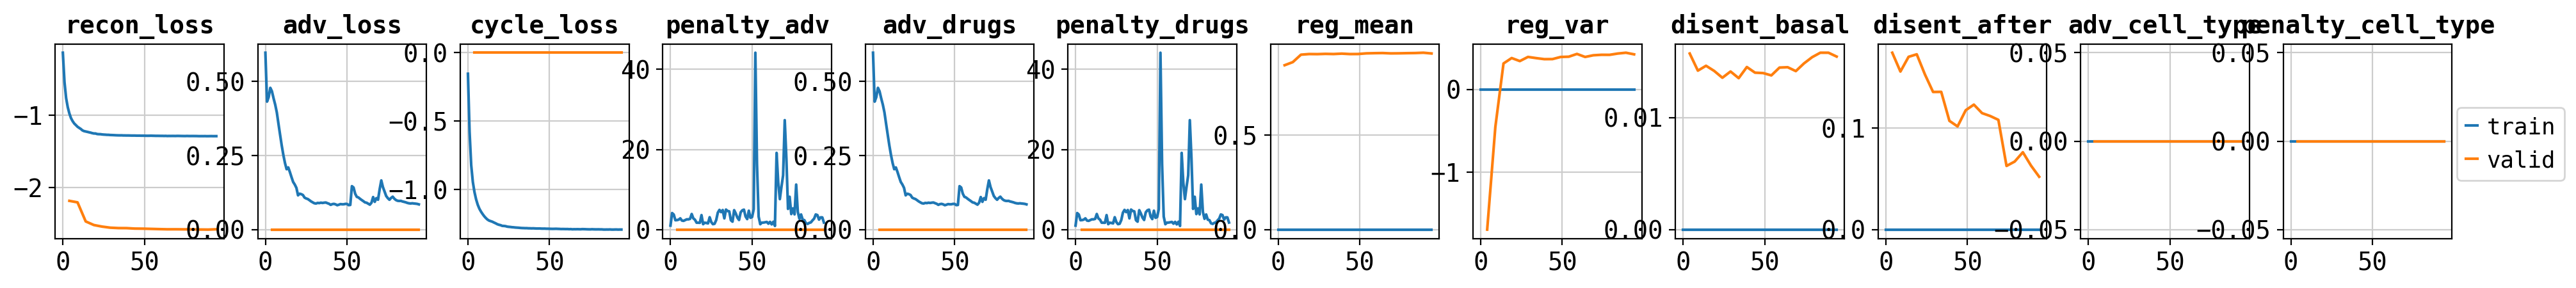

In [11]:
cpa.pl.plot_history(model)

In [12]:
cpa_api = cpa.ComPertAPI(adata, model)

In [13]:
cpa_plots = cpa.pl.CompertVisuals(cpa_api, fileprefix=None)

In [14]:
cpa_api.compute_comb_emb(thrh=30)

In [15]:
import pandas as pd

In [16]:
# construct prediction annadata
subset = adata[adata.obs['cell_type'] == 'A549'].copy()
genes_control = subset[subset.obs['condition'] == 'ctrl'].copy()

df = pd.DataFrame({'condition': ['TSC22D1+ctrl'] + ['KLF1+MAP2K6'], 
                   'dose_val': ['1+1'] + ['1+1'], 
                   'cell_type': ['A549']*2})

pred = cpa_api.predict(genes_control.X.toarray(), df)  # normally would put `sample=True` here
pred.obs['cov_drug_dose_name'] = pred.obs['cell_type'].astype(str) + '_' + pred.obs['condition'].astype(str) + '_' + pred.obs['dose_val'].astype(str)
pred.obs['cov_drug_dose_name'] = pred.obs['cov_drug_dose_name'].astype('category')
pred

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


AnnData object with n_obs × n_vars = 17814 × 5000
    obs: 'condition', 'dose_val', 'cell_type', 'uncertainty_cosine', 'uncertainty_euclidean', 'closest_cond_cosine', 'closest_cond_euclidean', 'cov_drug_dose_name'
    layers: 'variance'

In [17]:
adata.obs['cov_drug_dose_name'].unique()

['A549_ctrl_1', 'A549_TSC22D1+ctrl_1+1', 'A549_KLF1+MAP2K6_1+1', 'A549_CEBPE+RUNX1T1_1+1', 'A549_MAML2+ctrl_1+1', ..., 'A549_SNAI1+ctrl_1+1', 'A549_PLK4+STIL_1+1', 'A549_ZBTB10+ELMSAN1_1+1', 'A549_CDKN1C+ctrl_1+1', 'A549_C3orf72+FOXL2_1+1']
Length: 284
Categories (284, object): ['A549_AHR+FEV_1+1', 'A549_AHR+KLF1_1+1', 'A549_AHR+ctrl_1+1', 'A549_ARID1A+ctrl_1+1', ..., 'A549_ctrl+UBASH3B_1+1', 'A549_ctrl+ZBTB1_1+1', 'A549_ctrl+ZBTB25_1+1', 'A549_ctrl_1']

In [18]:
de_dict = adata[adata.obs.split == 'train'].uns['rank_genes_groups_cov']
de_dict = {k: adata.var_names for k, v in de_dict.items()}

In [19]:
pred_adata = pred.concatenate(adata, batch_key='source', batch_categories=['pred', 'true'])

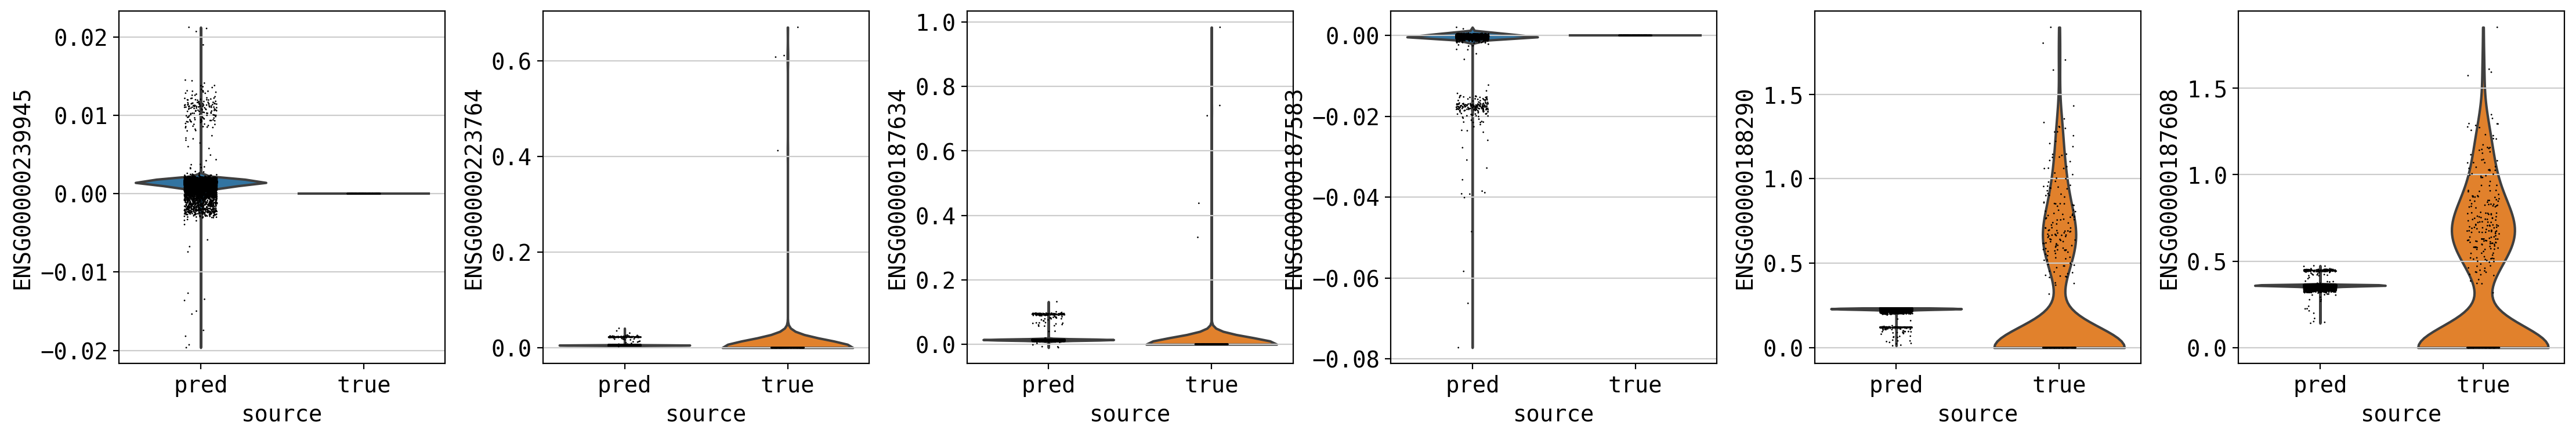

In [20]:
drug_name = 'TSC22D1+ctrl'
sc.pl.violin(
    pred_adata[pred_adata.obs.condition == drug_name],
    keys=de_dict[f'A549_{drug_name}_1+1'][:6],
    groupby='source')